## Testing recognition model

In [1]:
#Train
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import pandas as pd
import os
import csv
import numpy as np

import time
import threading

from fastai.vision import *
from fastai.metrics import error_rate
import re

#debug
from debug import *

In [4]:
#load learner
learn = load_learner("./data/numdet/numdet_png","numdet_resnet18_full_1.pkl")

In [5]:
class Roi_result():
    def __init__(self,image_result,tuple_x_y = (0,0), img_parse_list = [], error_code = None):
        self.image_result = image_result
        self.coords = tuple_x_y
        self.error_code = error_code #0-ok, 1-not found 2-too big frame
        self.img_parse_list = img_parse_list

def get_result(model,image):
    list_result = list(model.predict(image)[2])
    max_value = max(list_result)
    max_index = list_result.index(max_value)
    return max_index,max_value

def get_num_roi(path,model=None,win=[20,20,10,10],crop=[],new_height = 0, debug=True):
    #picture processing
    image_initial = cv2.imread(path)
    #conver to cv2->PIL: BGR->RGB!!!!!!!!!!!!!!!!!
    image_initial = cv2.cvtColor(image_initial, cv2.COLOR_BGR2RGB) 
    
    #crop
    if crop:
        h1,w1,h1_off,w1_off = crop[0],crop[1],crop[2],crop[3]
        image_initial = image_initial[h1_off:h1+h1_off,w1_off:w1+w1_off,:]   
    
    h0,w0 = image_initial.shape[:2]
    h2,w2 = h0,w0
    
    #resize
    if new_height!= 0: 
        h2 = new_height
        w2 = int(h2*w0/h0)
        image_initial = cv2.resize(image_initial,(w2,h2), interpolation = cv2.INTER_AREA)
    
    image_result = image_initial.copy()
    
    #define parsing frame. Should consist of "windows"
    win_h,win_w,h_step,w_step = win[0],win[1],win[2],win[3]
    
    h_count = 1+(h2-win_h)//h_step
    w_count = 1+(w2-win_w)//w_step
    
    frame_h = h_step*(h_count-1)+win_h
    frame_w = w_step*(w_count-1)+win_w

    color_map_list = []
    parse_elements_list = []
    
    if model!= None:
        if debug:
            color_map_list.append(Debug.Image(image_initial,"Initial"))

        if frame_h<=h2 and frame_w<=w2:
            mass_arr = []
            for h in range(h_count):
                for w in range(w_count):
                    cropped_window = image_initial[h*h_step:win_h+h*h_step,w*w_step:win_w+w*w_step,:]
                    cropped_window_resized = cv2.resize(cropped_window,(28,28), interpolation = cv2.INTER_AREA)
                    #gray = cv2.cvtColor(test_img_cv, cv2.COLOR_BGR2GRAY)
                    #blurred = cv2.GaussianBlur(gray, (1, 1), 0)
                    #colored = cv2.cvtColor(blurred,cv2.COLOR_GRAY2RGB)
                    #colored = np.clip(colored, 0, 255)

                    cropped_window_resized_img_format = Image(np.clip(pil2tensor(cropped_window_resized,np.float32).div_(255), 0, 1))
                    predict_result = get_result(model,cropped_window_resized_img_format)

                    #img_list.append(test_img_cv)
                    #predict_list.append(predict_result)

                    if predict_result[0] == 1:
                        image_result = cv2.rectangle(image_result, (w*w_step, h*h_step), (win_w+w*w_step, win_h+h*h_step), (0, 255, 0), 1)
                        if debug:
                            parse_elements_list.append(Debug.Image(cropped_window_resized,"EXIST"))
                        mass_arr.append([h*h_step + h_step/2,w*w_step + w_step/2])
            if mass_arr:            
                calc_arr = (np.array([k[0] for k in mass_arr]).mean().astype(int),np.array([ k[1] for k in mass_arr]).mean().astype(int))
                image_result = cv2.circle(image_result,(calc_arr[1],calc_arr[0]) , 3, (0, 0, 255), 2)
                return Roi_result(image_result,(calc_arr[1],calc_arr[0]),img_parse_list = parse_elements_list)
            else:
                print("Parse warning: nothing found")
                return Roi_result(image_result,error_code=1)
        else:
            print("Error: Frame is bigger than image")
            return Roi_result(image_result,error_code=2)
    else:
        return Roi_result(image_result)


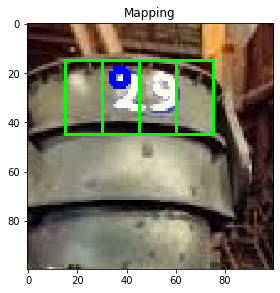

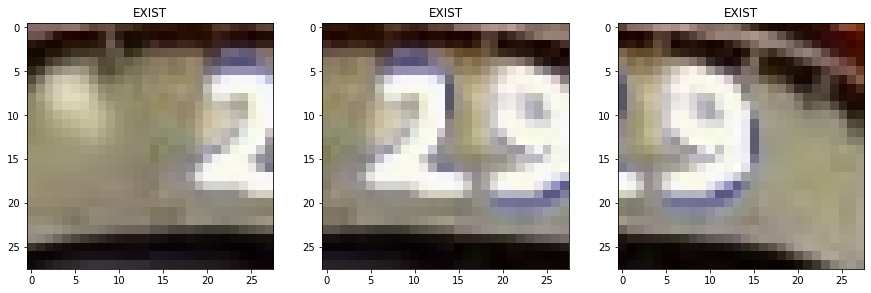

In [10]:
#### test parsing ####

#image_path = "data/test_numdet_1.jpg"
image_path = "data/test_ladlecar_1.jpg"
crop=[100,100,30,50]
win=[30,30,15,15]
roi_result = get_num_roi(image_path,model=learn,win=win,crop=crop,new_height = 0, debug=True)

Debug.show_images_list([Debug.Image(roi_result.image_result,"Mapping")], col_number = 3, height = 5)
Debug.show_images_list(roi_result.img_parse_list, col_number = 3, height = 5)